# Image Classification with Quantum Machine Learning

<div class="alert alert-block alert-danger">

**Goal**

Implement a quantum machine learning model for classification and predict labels accurately. 
</div>

<div class="alert alert-block alert-info">

**Plan**

First, you will learn how to implement a binary classifier for a simple dataset, then apply what you have learned to a different dataset.

**1. Tutorial - Binary classification of MNIST:** familiarize yourself with a typical workflow for QVC and QSVM in Qiskit, find the best combination of dimensions/feature maps/variational forms.

**2. Challenge - Binary classification of Fashion-MNIST:** Perform similar investigation as in the first part to find the best combination of dimentions/feature maps/variational forms.
</div>

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

import matplotlib 
matplotlib.rcParams['font.size'] = 14

import warnings
warnings.filterwarnings("ignore")

# scikit-learn imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Qiskit imports
from qiskit import Aer, execute
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms.classifiers import VQC

## Part 1: Tutorial - Binary classification of MNIST

In this part, you will apply quantum machine learning to the binary classification of handwritten numbers 4 and 9. 

### 1. Data preparation

The data we are going to work with at the beginning is a small subset of the well known handwritten digits dataset, which is available publicly. We will be aiming to differentiate between '4' and '9'. 


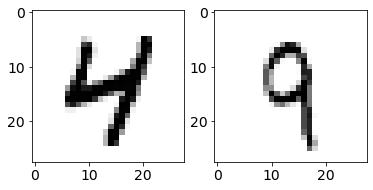

In [2]:
# Load MNIST dataset
DATA_PATH = './data/tutorial.npz'
data = np.load(DATA_PATH)

samples = data['samples']
labels  = data['labels']

# Visualize samples
fig = plt.figure()

LABELS = [4, 9]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(1, num_labels, i+1)
    img = samples[labels==LABELS[i]][0].reshape((28, 28))
    ax.imshow(img, cmap="Greys")

There are a total of 100 datapoints in the dataset. Of these, eighty will be labeled training datapoints, and the remaining twenty will be used as test datapoints. Each datapoint is a 28x28 image of a digit, collapsed into an array, where each element is an integer between 0 (white) and 255 (black). To use the dataset for quantum classification, we need to scale the range to between -1 and 1, and reduce the dimensionality (here we use 2 for simplicity).

In [3]:
# Split dataset
sample_train, sample_test, labels_train, labels_test = train_test_split(
    samples, labels, test_size=0.2, random_state=42)

# Standardize
ss = StandardScaler()
sample_train = ss.fit_transform(sample_train)
sample_test = ss.transform(sample_test)

# Reduce dimensions
N_DIM = 2
pca = PCA(n_components=N_DIM)
sample_train = pca.fit_transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalize
mms = MinMaxScaler((-1, 1))
sample_train = mms.fit_transform(sample_train)
sample_test = mms.transform(sample_test)

### 2. Data Encoding

We will take the classical data and encode it to the quantum state space using a quantum feature map. The choice of which feature map to use is important and may depend on the given dataset we want to classify. Here we'll look at the feature maps available in Qiskit, before selecting and customising one to encode our data.

### 2.1 Quantum Feature Maps
As the name suggests, a quantum feature map $\phi(\mathbf{x})$ is a map from the classical feature vector $\mathbf{x}$ to the quantum state $|\Phi(\mathbf{x})\rangle\langle\Phi(\mathbf{x})|$. This is facilitated by applying the unitary operation $\mathcal{U}_{\Phi(\mathbf{x})}$ on the initial state $|0\rangle^{n}$ where _n_ is the number of qubits being used for encoding.

The following feature maps currently available in Qiskit are those introduced in [**_Havlicek et al_.  Nature 567, 209-212 (2019)**](https://www.nature.com/articles/s41586-019-0980-2), in particular the `ZZFeatureMap` is conjectured to be hard to simulate classically and can be implemented as short-depth circuits on near-term quantum devices.

- [**`PauliFeatureMap`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliFeatureMap.html)
- [**`ZZFeatureMap`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZFeatureMap.html)
- [**`ZFeatureMap`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html)

The `PauliFeatureMap` is defined as:

```python
PauliFeatureMap(feature_dimension=None, reps=2, 
                entanglement='full', paulis=None, 
                data_map_func=None, parameter_prefix='x',
                insert_barriers=False)
```

and describes the unitary operator of depth $d$:

$$ \mathcal{U}_{\Phi(\mathbf{x})}=\prod_d U_{\Phi(\mathbf{x})}H^{\otimes n},\ U_{\Phi(\mathbf{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\mathbf{x})\prod_{k\in S} P_i\right), $$

which contains layers of Hadamard gates interleaved with entangling blocks, $U_{\Phi(\mathbf{x})}$, encoding the classical data as shown in circuit diagram below for $d=2$.

<center>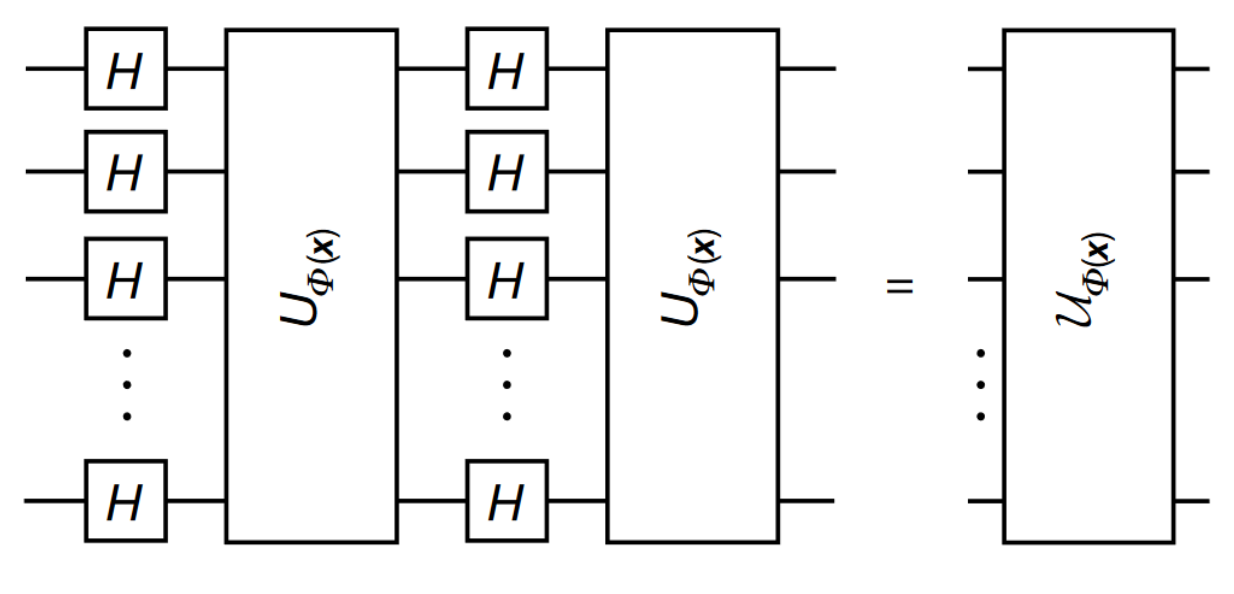</center>

Within the entangling blocks, $U_{\Phi(\mathbf{x})}$: $P_i \in \{ I, X, Y, Z \}$ denotes the Pauli matrices, the index $S$ describes connectivities between different qubits or datapoints: $S \in \{\binom{n}{k}\ combinations,\ k = 1,... n \}$, and by default the data mapping function $\phi_S(\mathbf{x})$ is 
$$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$$

when $k = 1, P_0 = Z$, this is the `ZFeatureMap`: 
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$

which is defined as:
```python
ZFeatureMap(feature_dimension, reps=2, 
            data_map_func=None, insert_barriers=False)
```

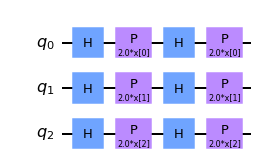

In [4]:
# 3 features, depth 2
map_z = ZFeatureMap(feature_dimension=3, reps=2)
map_z.decompose().draw('mpl')

Note the lack of entanglement in this feature map, this means that this feature map is simple to simulate classically and will not provide quantum advantage.

and when $k = 2, P_0 = Z, P_1 = ZZ$, this is the `ZZFeatureMap`: 
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$ 

which is defined as:
```python
ZZFeatureMap(feature_dimension, reps=2, 
             entanglement='full', data_map_func=None, 
             insert_barriers=False)
```

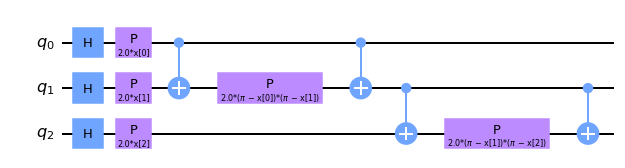

In [5]:
# 3 features, depth 1, linear entanglement
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='linear')
map_zz.decompose().draw('mpl')

Note that there is entanglement in the feature map, we can define the entanglement map:

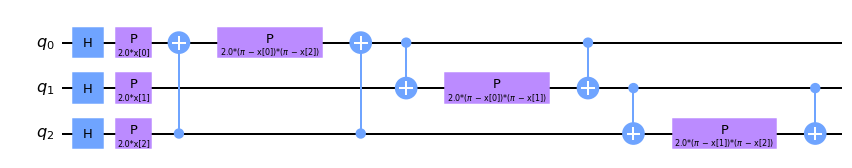

In [6]:
# 3 features, depth 1, circular entanglement
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='circular')
map_zz.decompose().draw('mpl')

We can customize the Pauli gates in the feature map, for example, $P_0 = X, P_1 = Y, P_2 = ZZ$:
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_{j} \phi_{\{j\}}(\mathbf{x}) \, Y_j\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, X_j\right) \, H^{\otimes n} \right)^d.$$ 

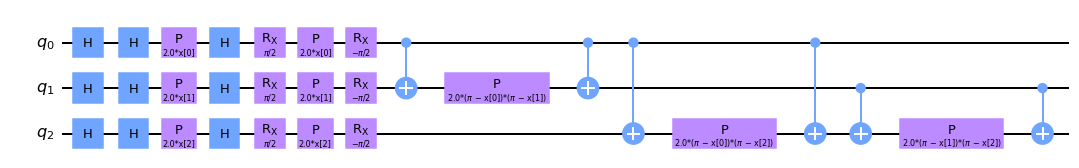

In [7]:
# 3 features, depth 1
map_pauli = PauliFeatureMap(feature_dimension=3, reps=1, paulis = ['X', 'Y', 'ZZ'])
map_pauli.decompose().draw('mpl')

The [**`NLocal`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.NLocal.html) and [**`TwoLocal`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) functions in Qiskit's circuit library can also be used to create parameterized quantum circuits as feature maps. 

```python
TwoLocal(num_qubits=None, reps=3, rotation_blocks=None, 
         entanglement_blocks=None, entanglement='full',  
         skip_unentangled_qubits=False, 
         skip_final_rotation_layer=False, 
         parameter_prefix='θ', insert_barriers=False, 
         initial_state=None)
```

```python
NLocal(num_qubits=None, reps=1, rotation_blocks=None, 
       entanglement_blocks=None, entanglement=None,   
       skip_unentangled_qubits=False, 
       skip_final_rotation_layer=False, 
       overwrite_block_parameters=True, 
       parameter_prefix='θ', insert_barriers=False, 
       initial_state=None, name='nlocal')
```

Both functions create parameterized circuits of alternating rotation and entanglement layers. In both layers, parameterized circuit-blocks act on the circuit in a defined way. In the rotation layer, the blocks are applied stacked on top of each other, while in the entanglement layer according to the entanglement strategy. Each layer is repeated a number of times, and by default a final rotation layer is appended.

In `NLocal`, the circuit blocks can have arbitrary sizes (smaller equal to the number of qubits in the circuit), while in `TwoLocal`, the rotation layers are single qubit gates applied on all qubits and the entanglement layer uses two-qubit gates.

For example, here is a `TwoLocal` circuit, with $R_y$ and $R_Z$ gates in the rotation layer and $CX$ gates in the entangling layer with circular entanglement:

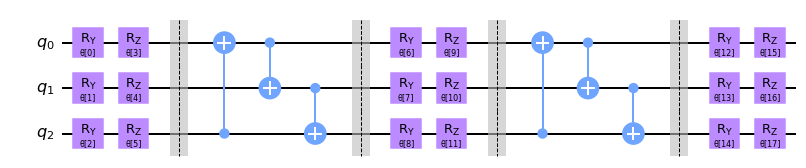

In [8]:
twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rz'], 
               entanglement_blocks='cx', entanglement='circular', insert_barriers=True)
twolocal.decompose().draw('mpl')

and the equivalent `NLocal` circuit:

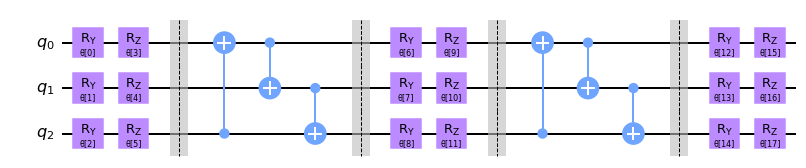

In [9]:
twolocaln = NLocal(num_qubits=3, reps=2,
               rotation_blocks=[RYGate(Parameter('a')), RZGate(Parameter('a'))], 
               entanglement_blocks=CXGate(), 
               entanglement='circular', insert_barriers=True)
twolocaln.decompose().draw('mpl')

Let's encode the first training sample using the `PauliFeatureMap`:

In [10]:
print(f'First training data: {sample_train[0]}')

First training data: [-0.47556223 -0.42254683]


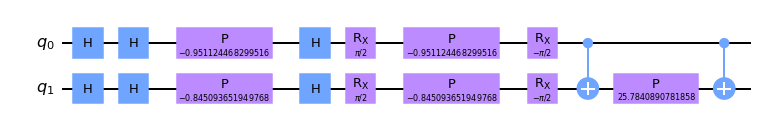

In [11]:
encode_map = PauliFeatureMap(feature_dimension=N_DIM, reps=1, paulis = ['X', 'Y', 'ZZ'])
encode_circuit = encode_map.bind_parameters(sample_train[0])
encode_circuit.decompose().draw(output='mpl')

<div class="alert alert-block alert-success">

**Exercise 1**

Construct a feature map to encode 2-dimensional data, using the `ZZFeatureMap` with 3 repetitions, 'circular' entanglement and the rest as default.
</div>

In [12]:
##############################
# your code here


##############################

### 2.2 Quantum Kernel Estimation

A quantum feature map, $\phi(\mathbf{x})$, naturally gives rise to a quantum kernel, $k(\mathbf{x}_i,\mathbf{x}_j)= \phi(\mathbf{x}_j)^\dagger\phi(\mathbf{x}_i)$, which can be seen as a measure of similarity: $k(\mathbf{x}_i,\mathbf{x}_j)$ is large when $\mathbf{x}_i$ and $\mathbf{x}_j$ are close. 

When considering finite data, we can represent the quantum kernel as a matrix: 
$K_{ij} = \left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2}$. We can calculate each element of this kernel matrix on a quantum computer by calculating the transition amplitude:
$$
\left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2} = 
\left| \langle 0^{\otimes n} | \mathbf{U_\phi^\dagger}(\mathbf{x}_j) \mathbf{U_\phi}(\mathbf{x_i}) | 0^{\otimes n} \rangle \right|^{2}
$$
assuming the feature map is a parameterized quantum circuit, which can be described as a unitary transformation $\mathbf{U_\phi}(\mathbf{x})$ on $n$ qubits. 

This provides us with an estimate of the quantum kernel matrix, which we can then use in a kernel machine learning algorithm, such as support vector classification.

As discussed in [**_Havlicek et al_.  Nature 567, 209-212 (2019)**](https://www.nature.com/articles/s41586-019-0980-2), quantum kernel machine algorithms only have the potential of quantum advantage over classical approaches if the corresponding quantum kernel is hard to estimate classically. 

As we will see later, the hardness of estimating the kernel with classical resources is of course only a necessary and not always sufficient condition to obtain a quantum advantage. 

However, it was proven recently in [**_Liu et al._ arXiv:2010.02174 (2020)**](https://arxiv.org/abs/2010.02174) that learning problems exist for which learners with access to quantum kernel methods have a quantum advantage over all classical learners.

With our training and testing datasets ready, we set up the `QuantumKernel` class with the `PauliFeatureMap`, and use the `BasicAer` `statevector_simulator` to estimate the training and testing kernel matrices.

In [13]:
pauli_map = PauliFeatureMap(feature_dimension=N_DIM, reps=1, paulis = ['X', 'Y', 'ZZ'])
pauli_kernel = QuantumKernel(feature_map=pauli_map, quantum_instance=Aer.get_backend('statevector_simulator'))

Let's calculate the transition amplitude between the first and second training data samples, one of the entries in the training kernel matrix.

In [14]:
print(f'First training data : {sample_train[0]}')
print(f'Second training data: {sample_train[1]}')

First training data : [-0.47556223 -0.42254683]
Second training data: [ 0.05258514 -0.67205174]


First we create and draw the circuit:

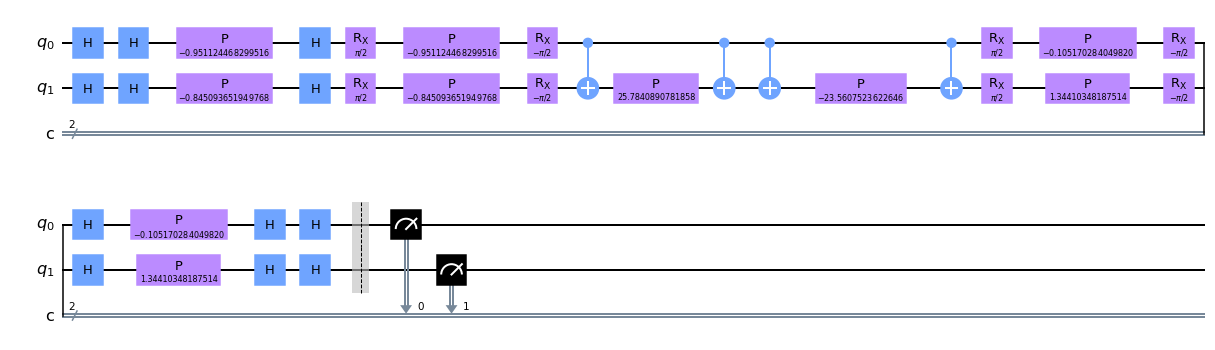

In [15]:
pauli_circuit = pauli_kernel.construct_circuit(sample_train[0], sample_train[1])
pauli_circuit.decompose().decompose().draw(output='mpl')

The parameters in the gates are a little difficult to read, but notice how the circuit is symmetrical, with one half encoding one of the data samples, the other half encoding the other. 

We then simulate the circuit. We will use the `qasm_simulator` since the circuit contains measurements, but increase the number of shots to reduce the effect of sampling noise. 

In [16]:
backend = Aer.get_backend('qasm_simulator')
job = execute(pauli_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(pauli_circuit)

The transition amplitude is the proportion of counts in the zero state:

In [17]:
print(f"Transition amplitude: {counts['0'*N_DIM]/sum(counts.values())}")

Transition amplitude: 0.2493896484375


This process is then repeated for each pair of training data samples to fill in the training kernel matrix, and between each training and testing data sample to fill in the testing kernel matrix. Note that each matrix is symmetric, so to reduce computation time, only half the entries are calculated explicitly.

Here we compute and plot the training and testing kernel matrices:

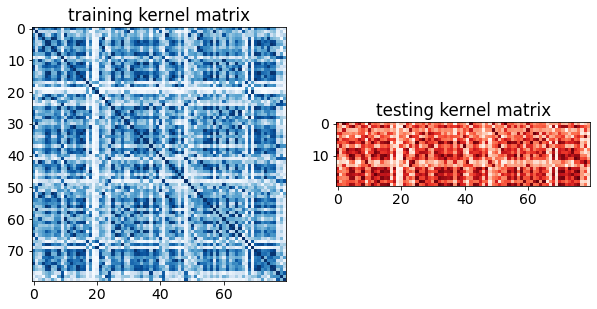

In [18]:
matrix_train = pauli_kernel.evaluate(x_vec=sample_train)
matrix_test = pauli_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

<div class="alert alert-block alert-success">

**Exercise 2a**

Using the `ZZFeatureMap` with 3 repetitions, `circular` entanglement and the rest as default, calculate the transition amplitude between `sample_train[0]` and `sample_train[1]`. Use the `qasm_simulator` with `shots=8192`, `seed_simulator=1024` and `seed_transpiler=1024`.
    
</div>

In [19]:
##############################
# your code here


##############################

<div class="alert alert-block alert-success">

**Exercise 2b**

Using the `ZZFeatureMap` with 3 repetitions, 'circular' entanglement and the rest as default, calculate and plot the training and testing kernel matrices. Use the `statevector_simulator`.
    
</div>

In [20]:
##############################
# your code here


##############################

### 2.3 Quantum Support Vector Machine (QSVM)

Introduced in [***Havlicek et al*.  Nature 567, 209-212 (2019)**](https://doi.org/10.1038/s41586-019-0980-2), the quantum kernel support vector classification algorithm consists of these steps:

<center>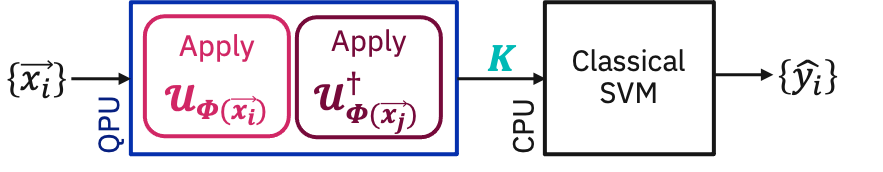</center> 


1. Build the train and test quantum kernel matrices.
    1. For each pair of datapoints in the training dataset $\mathbf{x}_{i},\mathbf{x}_j$, apply the feature map and measure the transition probability: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{x_j})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
    2. For each training datapoint $\mathbf{x_i}$ and testing point $\mathbf{y_j}$, apply the feature map and measure the transition probability: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{y_j})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
2. Use the train and test quantum kernel matrices in a classical support vector machine classification algorithm.

The `scikit-learn` `svc` algorithm allows us to [**define a custom kernel**](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) in two ways: by providing the kernel as a callable function or by precomputing the kernel matrix. We can do either of these using the `QuantumKernel` class in Qiskit.

The following code takes the training and testing kernel matrices we calculated earlier and  provides them to the `scikit-learn` `svc` algorithm:

In [21]:
pauli_svc = SVC(kernel='precomputed')
pauli_svc.fit(matrix_train, labels_train)
pauli_score = pauli_svc.score(matrix_test, labels_test)

print(f'Precomputed kernel classification test score: {pauli_score*100}%')

Precomputed kernel classification test score: 50.0%


In [22]:
def plot_predicted_49(sample_train, labels_train, sample_test, labels_test, predict):
    from matplotlib.lines import Line2D
    plt.figure(figsize=(12, 6))

    for feature, label in zip(sample_train, labels_train):
        marker = 'o' 
        color = 'tab:green' if label == 4 else 'tab:blue'
        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    for feature, label, pred in zip(sample_test, labels_test, predict):
        marker = 's' 
        if pred == 0: pred = 4
        elif pred == 1: pred = 9
        color = 'tab:green' if pred == 4 else 'tab:blue'
        if label != pred:  # mark wrongly classified
            plt.scatter(feature[0], feature[1], marker='o', s=500, linewidths=2.5,
                        facecolor='none', edgecolor='tab:red')

        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    legend_elements = [
        Line2D([0], [0], marker='o', c='w', mfc='tab:green', label='4', ms=15),
        Line2D([0], [0], marker='o', c='w', mfc='tab:blue', label='9', ms=15),
        Line2D([0], [0], marker='s', c='w', mfc='tab:green', label='predict 4', ms=10),
        Line2D([0], [0], marker='s', c='w', mfc='tab:blue', label='predict 9', ms=10),
        Line2D([0], [0], marker='o', c='w', mfc='none', mec='tab:red', label='wrongly classified', mew=2, ms=15)
    ]

    plt.legend(handles=legend_elements, bbox_to_anchor=(1, 0.7))
    
    plt.title('Training & Test Data predictions')
    plt.xlabel('$x$')
    plt.ylabel('$y$')

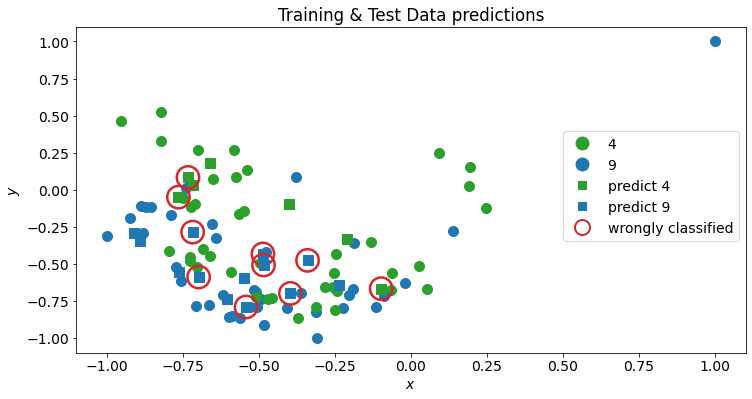

In [23]:
plot_predicted_49(sample_train, labels_train, sample_test, labels_test, pauli_svc.predict(matrix_test))

<div class="alert alert-block alert-success">

**Exercise 3**

Use the training and kernel matrices you calculated earlier using the `ZZFeatureMap` in the `sklearn svc` algorithm. Plot your predictions using the `plot_predicted_49` function.

</div>

In [24]:
##############################
# your code here



##############################

### 2.4 Quantum Variational Classifier (QVC)

Variational algorithms were introduced in 2014, with the variational eigensolver in [***Peruzzo et al.* Nature Communications, 5:4213 (2014)**](https://doi.org/10.1038/ncomms5213) and the quantum approximate optimization algorithm in [***Farhi et al.* arXiv:1411.4028**](https://arxiv.org/abs/1411.4028). They are near-term algorithms, that can be executed on current quantum computers in concert with classical computers. 

Using a parameterized quantum circuit, or ansatz, $U(\theta)$, we prepare a state $\psi(\theta) \rangle = U(\theta) |0 \rangle$, and measure the expectation value using a quantum computer. We define a cost function $C(\theta)$, that determines how good $\theta$ is for the problem we are trying to solve. We use a classical computer to calculate the cost function and provide updated circuit parameters using an optimization algorithm. The goal of the algorithm is to find the circuit parameters $\theta$ for the parameterized quantum circuit $U(\theta)$ that minimizes the cost function $C(\theta)$. 

<figure>
  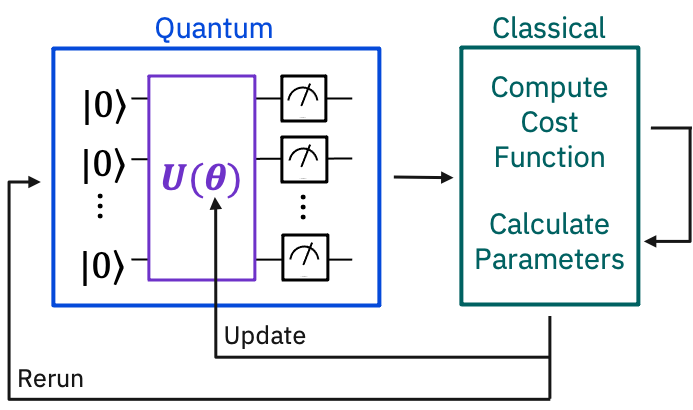
</figure> 

The variational quantum classifier is a variational algorithm where the measured expectation value is interpreted as the output of a classifier, introduced by mutiple groups in 2018. For a binary classification problem, with input data vectors $\vec{x}_i$ and binary output labels $y_i = \{0,1\}$; for each input data vector, we build a parameterized quantum circuit whose outputs is the quantum state: 
$$ |\psi(\vec{x}_i;\vec{\theta}) \rangle =  U_{W(\vec{\theta})}U_{\phi(\vec{x}_i)}|0 \rangle$$
where $U_{W(\vec{\theta})}$ corresponds to the variational circuit unitary and $U_{\phi(\vec{x}_i)}$ corresponds to the data encoding circuit unitary. After creating and measuring the circuit of $n$ qubits, we are left with a $n$ length bitstring from which we must derive a binary output which will be our classification result. This is done with the help of a boolean function $f: \{0, 1\}^{n} \rightarrow \{0, 1\}$. The parity function tends to be used.

<figure>
  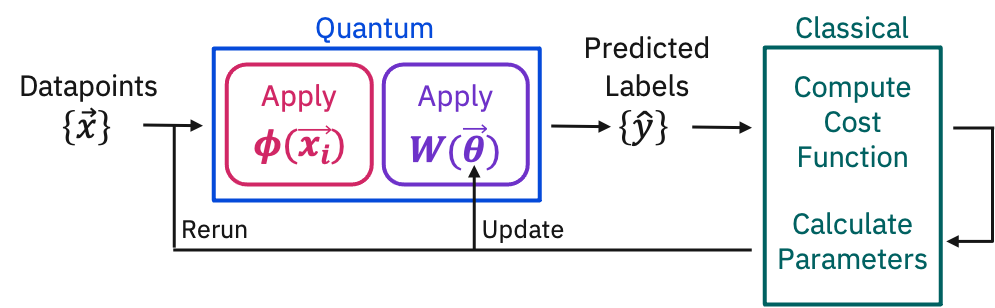
</figure>

In the training phase, we are trying to find the values for $\vec{\theta}$ that give us the best predictions. The classical computer compares the predicted labels $\hat{y_i}$, to the provided labels $y_i$, and we calculate the success of our predictions using a cost function. Based on this cost, the classical computer chooses another value for $\vec{\theta}$ using a classical optimization algorithm. This new $\vec{\theta}$ is then used to run a new circuit, and the process is repeated until the cost function stabilizes.

Qiskit has an implementation of the variational quantum classifer in the [**`VQC`**](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.VQC.html) class. Let's use it on this dataset. 

First, we need to one hot encode our labels, as required by the algorithm.

In [25]:
encoder = OneHotEncoder()
labels_train_oh = encoder.fit_transform(labels_train.reshape(-1, 1)).toarray()
labels_test_oh = encoder.fit_transform(labels_test.reshape(-1, 1)).toarray()

Second, we need to prepare our classification circuit. We will use the same `PauliFeatureMap` as above as our data encoding circuit. 

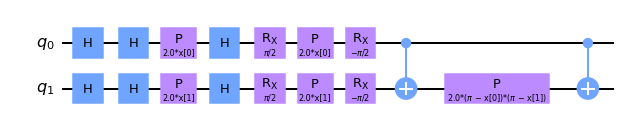

In [26]:
feature_map = PauliFeatureMap(feature_dimension=N_DIM, reps=1, paulis = ['X', 'Y', 'ZZ'])
feature_map.decompose().draw('mpl')

For the variational form, you can use the `TwoLocal` or `NLocal` circuits introduced earlier to create your own. Qiskit also contains the hardware efficient SU(2) 2-local circuit [**`EfficientSU2`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.EfficientSU2.html), as well as the real amplitudes 2-local circuit [**`RealAmplitudes`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html), both introduced in [**_Kandala et al._  Nature 549, 242–246 (2017)**](https://doi.org/10.1038/nature23879).

```python 
    EfficientSU2(num_qubits=None, su2_gates=None, entanglement='full', reps=3, 
                 skip_unentangled_qubits=False, skip_final_rotation_layer=False, 
                 parameter_prefix='θ', insert_barriers=False, initial_state=None,
                 name='EfficientSU2')
```

```python
    RealAmplitudes(num_qubits=None, entanglement='full', reps=3, 
                   skip_unentangled_qubits=False, skip_final_rotation_layer=False,
                   parameter_prefix='θ', insert_barriers=False, initial_state=None,
                   name='RealAmplitudes')
```

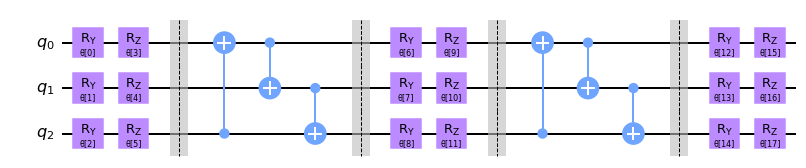

In [27]:
su2 = EfficientSU2(num_qubits=3, reps=2, entanglement='circular', insert_barriers=True)
su2.decompose().draw('mpl')

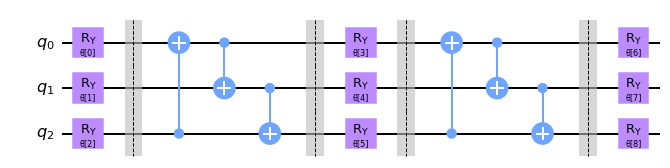

In [28]:
realamp = RealAmplitudes(num_qubits=3, reps=2, entanglement='circular', insert_barriers=True)
realamp.decompose().draw('mpl')

Let's use the `EfficientSU2` circuit as our variational form:

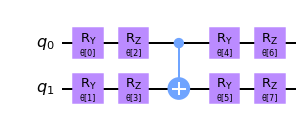

In [29]:
var_form = EfficientSU2(N_DIM, reps=1)
var_form.decompose().draw('mpl')

Putting the two circuits together to visualise the full classification circuit:

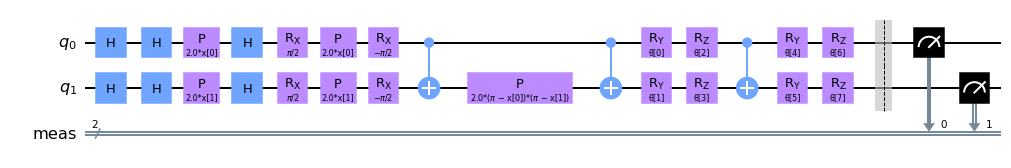

In [30]:
classify_circuit = feature_map.compose(var_form)
classify_circuit.measure_all()
classify_circuit.decompose().draw(output="mpl")

<div class="alert alert-block alert-success">

**Exercise 4**

Create and visualise a classification circuit using the `ZZFeatureMap` and `RealAmplitudes`, both with two repetitions.

</div>

In [31]:
##############################
# your code here



##############################

Third, we set up and run the `VQC` algorithm, setting initial variational circuit parameters for reproducibility and creating a callback function to plot the optimization steps.

In [32]:
# Optimizer callback function for plotting purposes
def store_intermediate_result(evaluation, parameter, cost, stepsize, accept):
    evaluations.append(evaluation)
    parameters.append(parameter)
    costs.append(cost)

In [33]:
#initial_point = np.random.random(var_form.num_parameters)
initial_point = np.array([0.39652776, 0.99908266, 0.43333887, 0.57323871, 
                          0.61557793, 0.47460135, 0.17678561, 0.00906747])

In [34]:
parameters = []
costs = []
evaluations = []

vqc = VQC(feature_map=feature_map,
          ansatz=var_form,
          loss='cross_entropy',
          optimizer=SPSA(callback=store_intermediate_result),
          initial_point=initial_point,
          quantum_instance=Aer.get_backend('statevector_simulator'))

In [35]:
vqc.fit(sample_train, labels_train_oh)

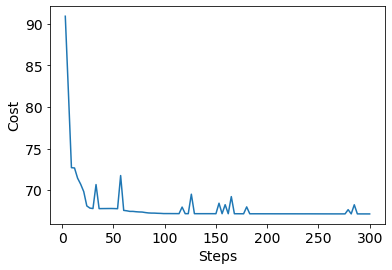

In [36]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

Fourth, we evaluate the trained classifier on the test data.

In [37]:
vqc.score(sample_test, labels_test_oh)

0.45

In [38]:
vqc_predict = vqc.predict(sample_test)
vqc_predict = np.argmax(vqc_predict, axis = 1) # decoding the one hot encoding for plotting

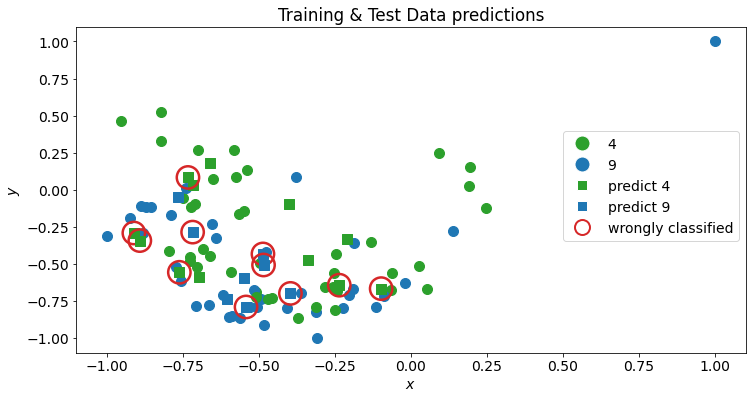

In [39]:
plot_predicted_49(sample_train, labels_train, sample_test, labels_test, vqc_predict)

<div class="alert alert-block alert-success">

**Exercise 5**

Use the classification circuit you created earlier using the  the `ZZFeatureMap` and `RealAmplitudes`, both with two repetitions in the variational quantum classifier. Plot your predictions using the `plot_predicted_49` function.

</div>

In [40]:
##############################
# your code here



##############################

## Part 2: Challenge - Binary classification of Fashion-MNIST

In this part, you will use what you have learned so far to create a binary classifier for clothing images and work on improving its accuracy. 
    
<div class="alert alert-block alert-warning">

**Goal**: Implement a binary classifier using QSVM or VQC and achieve 70% accuracy on the test clothing image dataset.

**Dataset**: Fashion-MNIST clothing image dataset.
    
</div>

### 1. Data preparation
The data we are working with here is a small subset of clothing image dataset called Fashion-MNIST, which is a variant of the MNIST dataset. We aim to classify the following labels.
- label 0: tshirt/top
- label 3: dress

First, let's load the dataset and display one image for each class.

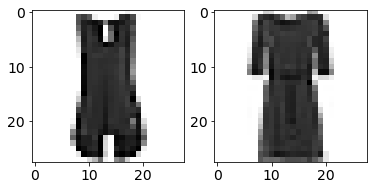

In [41]:
# Load MNIST dataset
DATA_PATH = './data/challenge.npz'
data = np.load(DATA_PATH)

sample_train = data['sample_train']
labels_train = data['labels_train']

# Split train data
sample_train, sample_val, labels_train, labels_val = train_test_split(
    sample_train, labels_train, test_size=0.2, random_state=42)

# Load test data
sample_test = data['sample_test']
labels_test = data['labels_test']

# Visualize samples
fig = plt.figure()

LABELS = [0, 3]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(1, num_labels, i+1)
    img = sample_train[labels_train==LABELS[i]][2].reshape((28, 28))
    ax.imshow(img, cmap="Greys")

Then, we preprocess the dataset in the same way as before.
- Standardization
- PCA
- Normalization

Note that you can change the number of features here by changing N_DIM.

In [42]:
# Standardize
standard_scaler = StandardScaler()
sample_train = standard_scaler.fit_transform(sample_train)
sample_val = standard_scaler.transform(sample_val)
sample_test = standard_scaler.transform(sample_test)

# Reduce dimensions
N_DIM = 5
pca = PCA(n_components=N_DIM)
sample_train = pca.fit_transform(sample_train)
sample_val = pca.transform(sample_val)
sample_test = pca.transform(sample_test)

# Normalize
min_max_scaler = MinMaxScaler((-1, 1))
sample_train = min_max_scaler.fit_transform(sample_train)
sample_val = min_max_scaler.transform(sample_val)
sample_test = min_max_scaler.transform(sample_test)

### 2. Data Modelling

Use `sample_train/labels_train` to build your QSVM or VQC models and `sample_val/labels_val` to validate the models.

### 3. Data Prediction

Use `sample_test/labels_test` to test your QSVM or VQC model.